## Validate branch simulation

In [15]:
from __future__ import print_function

import numpy as np
import pandas as pd
import xray

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

Load in data from two different sources:

1. Monthly-averaged output from `arg_comp` with `PD` emissions
2. High-frequency instantaneous output from `aerosol_dists` simulation which branched from **(1)**

In [2]:
import os
DATA_ROOT_DIR = "/Volumes/legion_home/CESM_archive/act_aie_aci/"
instant_data = xray.open_dataset(
    os.path.join(DATA_ROOT_DIR, "aerosols", "aerosol_dists_PD.sample.nc"), decode_times=False)
average_data = xray.open_mfdataset(
    os.path.join(DATA_ROOT_DIR, "PD", "arg_comp", "atm", "hist",
                 "arg_comp_PD.cam.h0.*.nc"), decode_times=False)
TIMES_SET = False

Are the same set of variables available in each dataset?

In [3]:
for v in instant_data.variables:
    if not (v in average_data.variables):
        print("{:>15s} is missing!".format(v))

No output means we're good to go! So we can go ahead and subset from the average dataset to reduce the amount of data we have to manipulate. Simultaneously, let's reduce the amount of data that we have to work with in the following ways:

- Get rid of the first five years of data from the "averaged" case; it's spin-up and not useful. Note that the timestamp of the "averaged" data denotes the *end* of the period over which it was averaged, so we should adjust the dates in place first. To facilitate this, the times were not decoded when read in earlier.

In [12]:
## Re-index from year 0 to year 2000, accounting for month offset
if not TIMES_SET:
    
    ## Promote to dataset
    average_data_coords = average_data.coords.to_dataset()
    instant_data_coords = instant_data.coords.to_dataset()
    print("setting calendar dates...")
    
    average_data_coords.time.values += 2000.*365
    instant_data_coords.time.values += 2000.*365
    
    ## Decode
    average_data = xray.decode_cf(average_data)
    instant_data = xray.decode_cf(instant_data)
    
    # AVERAGE DATA
    # Shift monthly offsets using Pandas machinery
    atimes = average_data.time.to_index()
    atimes = atimes.shift(-1, 'MS')
    
    # INSTANT DATA
    # Add constant offset of 9 years to align with last year of average data
    itimes = instant_data.time.to_index()
    itimes = itimes + np.timedelta64(9, 'Y')
    
    # Re-assign to original dataset
    average_data = average_data.assign_coords(time=atimes)
    instant_data = instant_data.assign_coords(time=itimes)
    TIMES_SET = True

setting calendar dates...


/Users/daniel/anaconda/envs/marc_analysis/lib/python3.4/site-packages/xray/conventions.py:779: UserWarning: CF decoding is overwriting dtype
  warnings.warn("CF decoding is overwriting dtype")


In [13]:
## Slice off first five years
average_data = average_data.sel(time=slice('2006-01', None))

Compare the global average, annual cycle over the final years of the "averaged" case to monthly-aggregate estimates from the "instantaneous" case. Use global aerosol loading of **BC**, **OC**, and **SUL** for the comparison.

BC
MBS
OC
SUL
pSUL


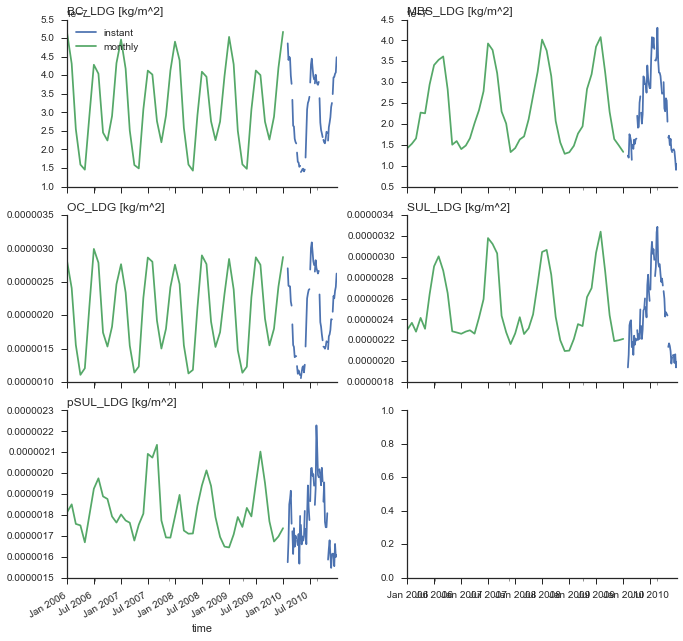

In [27]:
from marc_analysis.analysis import global_avg

def calc_loading(src):
    field = "{}_LDG".format(src)

    monthly = global_avg(average_data[field])
    instant = global_avg(instant_data[field]
                             .isel(time=slice(5,None))
#                              .resample('MS', dim='time', how='mean')
    )

    return pd.DataFrame({'instant': instant.to_series(),
                         'monthly': monthly.to_series()})

flds = ['BC', 'MBS', 'OC', 'SUL', 'pSUL']

nrow, ncol = 3, 2
aspect, size = 16./10., 3.
figsize = (ncol * size * aspect, nrow * size)

fig, axes = plt.subplots(nrow, ncol, figsize=figsize, sharex=True)
for i, (ax, fld) in enumerate(zip(list(axes.flat), flds)):
    print(fld)
    plot_kws = dict(legend=False)
    if i == 0:
        plot_kws['legend'] = True

    loading = calc_loading(fld)
    loading.plot(ax=ax, **plot_kws)
    ax.set_title(fld + "_LDG [kg/m^2]", loc='left')

sns.despine(fig)
plt.tight_layout()

import os
save_fn = os.path.join(
    "/Users/daniel/Dropbox_MIT/Research/results/", 
    "CESM_pcm_activation",
    "validate_ldg.png"
)
plt.savefig(save_fn)

Taking anything after the first few timesteps should be just fine.